In [1]:
import hoomd
import hoomd.hpmc
import ex_render
import math
from matplotlib import pyplot
import numpy
%matplotlib inline

# Selecting move sizes

HPMC allows you to set the translation and rotation move sizes. Set the move size too small and almost all trial moves are accepted, but it takes many time steps to move the whole system an appreciable amount. Set the move size too large and individual moves will advance the system significantly, but most of the trial moves are rejected.

To find the true optimal move size, you need to define the slowest evolving order parameter in the system. Then perform simulations at many move sizes and find the one with where that order parameter has the fastest decorrelation time.

## Acceptance rule of thumb

In a wide range of systems, the optimal move size is one where the move acceptance ratio is 20%. This rule applies in moderately dense to dense system configurations. HPMC can auto-tune the move size to meet a given acceptance ratio. To demonstrate, here is the hard square tutorial script:

In [2]:
hoomd.context.initialize('--mode=cpu');
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.2), n=10);
mc = hoomd.hpmc.integrate.convex_polygon(d=0.1, a=0.1, seed=1);
square_verts = [[-0.5, -0.5], [0.5, -0.5], [0.5, 0.5], [-0.5, 0.5]];
mc.shape_param.set('A', vertices=square_verts);

log1 = hoomd.analyze.log(filename="log-output.log",
                         quantities=['hpmc_sweep',
                                     'hpmc_translate_acceptance',
                                     'hpmc_rotate_acceptance',
                                     'hpmc_d',
                                     'hpmc_a',
                                     'hpmc_move_ratio',
                                     'hpmc_overlap_count'],
                         period=10,
                         overwrite=True);

HOOMD-blue v2.1.5 CUDA (7.5) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 03/12/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 100 particles


Activate the tuner and tell it to tune both the **d** and **a** moves. 

You can restrict it to only tune one of the move types and provide a range of move sizes the tuner is allowed to choose from. This example sets a maximum translation move size of half the particle width, and a maximum rotation move size that rotates the square all the way to the next symmetric configuration.

In [3]:
tuner = hoomd.hpmc.util.tune(obj=mc, tunables=['d', 'a'], max_val=[0.5, 2*math.pi/4], target=0.2);

Update the tuner between short runs. It will examine the acceptance ratio and adjust the move sizes to meet the target acceptance ratio.

In [4]:
for i in range(20):
    hoomd.run(100, quiet=True);
    tuner.update();

In this example, the acceptance ratios converges after only 10 steps of the tuner.

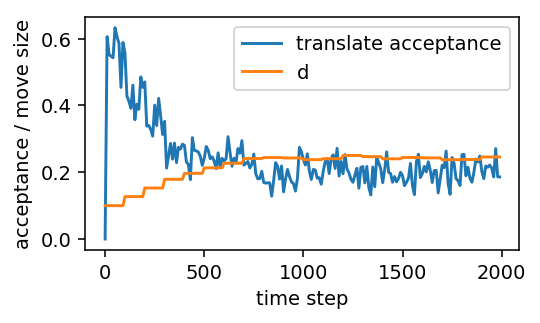

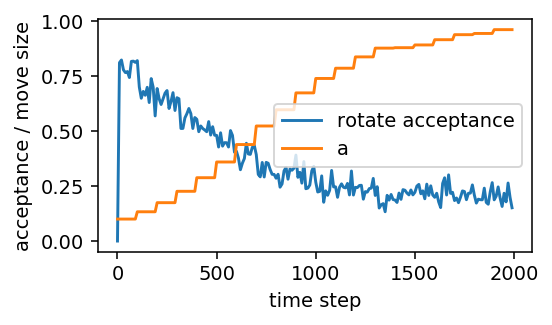

In [5]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,2], label='translate acceptance');
pyplot.plot(data[:,0], data[:,4], label='d');
pyplot.xlabel('time step');
pyplot.ylabel('acceptance / move size');
pyplot.legend();

pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,3], label='rotate acceptance');
pyplot.plot(data[:,0], data[:,5], label='a');
pyplot.xlabel('time step');
pyplot.ylabel('acceptance / move size');
pyplot.legend(loc='right');

## Sampling equilibrium states

Strictly speaking, changing the move size with an tuner **VIOLATES DETAILED BALANCE**. When you make ensemble averages, do not include the period of the simulation where you executed the tuner. This example shows how to make the equilibrium run as a second stage of the script.

In [6]:
d = hoomd.dump.gsd("trajectory-square.gsd", period=1000, group=hoomd.group.all(), overwrite=True);
hoomd.run(10000);

** starting run **
Time 00:00:03 | Step 12000 / 12000 | TPS 4313.37 | ETA 00:00:00
Average TPS: 4294.14
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.190447
notice(2): Average rotate acceptance:    0.1977
notice(2): Trial moves per second:        1.70363e+06
notice(2): Overlap checks per second:     2.51579e+07
notice(2): Overlap checks per trial move: 14.7673
notice(2): Number of overlap errors:      0
** run complete **


Examine how the system configuration evolves over time. [ex_render](ex_render.py) is a helper script that builds animated gifs from trajectory files and system snapshots. It is part of the [hoomd-examples](https://bitbucket.org/glotzer/hoomd-examples) repository and designed only to render these examples.

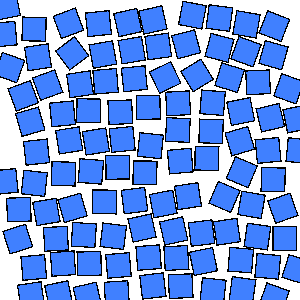

In [7]:
ex_render.display_movie(lambda x: ex_render.render_polygon_frame(x, square_verts), 'trajectory-square.gsd')